In [1]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import pandas as pd
import numpy as np

## Part 1 [3 point] Analyze and prepare.
1. Analyze distribution of labels and draw a plot.
2. Remove unexcepted labels from data (if it's needed) and describe how (if it's needed).

In [2]:
! ls data/mipt-nlp-hw2-2021

sample_submission.csv  train.csv  valid_tokens.csv


Загрузим данные и посмотрим на них

In [3]:
train_path = 'data/mipt-nlp-hw2-2021/train.csv'
valid_tokens_path = 'data/mipt-nlp-hw2-2021/valid_tokens.csv'
train_df = pd.read_csv(train_path, index_col=0)
valid_tokens_df = pd.read_csv(valid_tokens_path, index_col=0)
train_df.head()

,tokens,tags
0,В Пакистане роходят акции исламистов против от...,O B_LOC O O O O O B_ORG I_ORG O B_PER
1,Как сообщает Пакистанская служба Радио Свобода...,O O B_ORG I_ORG I_ORG I_ORG O O B_LOC O O O O ...
2,В городе Карачи ющие жгли шины .,O O B_LOC O O O O
3,В провинции Пенджаб толкновения с полицией .,O O B_LOC O O O O
4,Пакистанские силы безопасности установили охра...,O O O O O O O O O


Построим гистограму по встречаемости лейблов

In [6]:
labels = []  
for line in train_df['tags'].to_list():
    labels += str(line).split()

(array([5.2687e+04, 1.4030e+03, 1.3310e+03, 1.9030e+03, 1.0190e+03,
        8.6000e+01, 7.8000e+01, 5.0000e+00, 2.1500e+02, 3.0700e+02]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

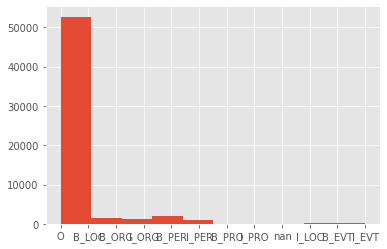

In [26]:
plt.hist(labels)

Токен "O" преобладает, как и ожидалось.
Посмотрим на распределение токенов без него

(array([1592., 1403., 1331., 1903., 1019.,   86.,   78.,    5.,  215.,
         307.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

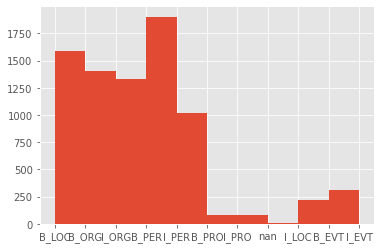

In [27]:
plt.hist(list(filter(lambda label: label != "O", labels)))

Видно что есть выбросы в виде токенов "nan".
Посмотрим на распределение токенов без выбросов и рассматривая токены продолжения как одтельный.
Видно что преобладают люди, организации и места

(array([1807.,    0., 2734.,    0.,    0., 2922.,    0.,  164.,    0.,
         307.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

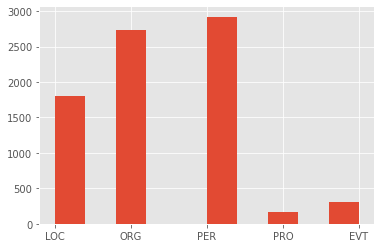

In [28]:
plt.hist(list(map(lambda label: label.split('_')[1], filter(lambda label: label != "O" and label != "nan", labels))))

Почистим от выбросов

In [7]:
print(train_df[train_df['tags'].isna()])
train_df = train_df.dropna()

     tokens tags
382     NaN  NaN
765     NaN  NaN
1342    NaN  NaN
1397    NaN  NaN
2017    NaN  NaN


## Part 2 [4 point] Try a baseline.
1. Performe baseline from this tutorial https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html.
2. Make crossvalidation.
3. Describe your features and results.

Далее в качестве бейзлайна используем sklearn-crf и код из туториала.
Пока не используем POS-теги в качестве фичей или словари, а является ли слово именем собственным, предыдущее и следующее слово в предложении, окончания.

In [30]:
def word2features(sent, i):
    word = sent[i]
#     postag = sent[i][1]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
#         'postag': postag,
#         'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1]
#         postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
#             '-1:postag': postag1,
#             '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1]
#         postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
#             '+1:postag': postag1,
#             '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [8]:
train_df['tokens'] = train_df['tokens'].apply(str.split)

In [34]:
sent2features(train_df['tokens'][0])[1]

{'bias': 1.0,
 'word.lower()': 'пакистане',
 'word[-3:]': 'ане',
 'word[-2:]': 'не',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 '-1:word.lower()': 'в',
 '-1:word.istitle()': True,
 '-1:word.isupper()': True,
 '+1:word.lower()': 'роходят',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False}

In [41]:
X = train_df['tokens'].apply(sent2features).to_list()
y = train_df['tags'].apply(str.split).to_list()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

Обучим модель

In [44]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.58 s


/home/care1e55/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [46]:
labels = list(crf.classes_)
labels

['O',
 'B_PER',
 'I_PER',
 'B_ORG',
 'I_ORG',
 'B_LOC',
 'I_LOC',
 'B_EVT',
 'I_EVT',
 'B_PRO',
 'I_PRO']

Оценим качество на тестовом датасете

In [55]:
y_pred = crf.predict(X_test)
print('With O:', metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))
labels.remove('O')
print('Without O:', metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels))

With O: 0.9599363884082782
Without O: 0.7975734380177905


In [68]:
y_pred = crf.predict(X_test)

Подготовим submit отфильтровав токены которых нет в таргете заменив их на "О"

In [21]:
lbl_dict = {
    'B_ORG': 0, 
    'I_PER': 1, 
    'I_LOC': 2, 
    'I_ORG': 3, 
    'B_LOC': 4, 
    'B_PER': 5, 
    'O': 6, 
    'B_EVT': 6, 
    'I_EVT': 6,
    'B_PRO': 6, 
    'I_PRO': 6
}

In [74]:
submission_tokens = valid_tokens_df['tokens'].str.split().apply(sent2features).to_list()

In [75]:
submission_predict = crf.predict(submission_tokens)

In [76]:
encoded_pred = [[lbl_dict[j] for j in i] for i in submission_predict]

In [77]:
flattened_encoded_pred = [j for i in encoded_pred for j in i]

In [83]:
submission_df = pd.DataFrame({"Id": list(range(len(flattened_encoded_pred))), "Predicted": flattened_encoded_pred})

In [84]:
submission_df.to_csv( "data/sample_submission.csv", sep=",", index=False)

Подберем гиперпараметры модели на кроссвалидации и воспользуемся кодом выше для подготовки сабмит лучшей модели

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer

In [87]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/care1e55/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished


CPU times: user 21.4 s, sys: 1.56 s, total: 22.9 s
Wall time: 2min 20s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4f07bb98b0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4f07b29340>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B_PER', 'I_PER', 'B_ORG', 'I_ORG', 'B_LOC', 'I_LOC', 'B_EVT', 'I_EVT', 'B_PRO', 'I_PRO']),
                   verbose=1)

In [88]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
crf = rs.best_estimator_

best params: {'c1': 0.00526955618740208, 'c2': 0.02351374190510522}
best CV score: 0.7682867338076004
model size: 1.30M


## Part 3. [2 point] Try your favorite ML algorithm.
1. Make submission to leaderboard and beat a baseline with your favorite ML algorithm (0.55 macro f1).
2. Plot learning curves (if your algo is not rule-based).
3. Describe your solution (or one of your solutions) and results.
Also here your can do many experiments.

In [34]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
import gensim
from src.learner import NerLearner, validate_step

warnings.filterwarnings("ignore")
# sys.path.append("mipt-nlp2021/seminars/sem4/")

In [90]:
model = gensim.models.KeyedVectors.load('data/araneum_none_fasttextskipgram_300_5_2018.model')

INFO:gensim.utils:loading Word2VecKeyedVectors object from data/araneum_none_fasttextskipgram_300_5_2018.model
INFO:gensim.utils:loading vectors_ngrams from data/araneum_none_fasttextskipgram_300_5_2018.model.vectors_ngrams.npy with mmap=None
INFO:gensim.utils:loading vectors from data/araneum_none_fasttextskipgram_300_5_2018.model.vectors.npy with mmap=None
INFO:gensim.utils:loading vectors_vocab from data/araneum_none_fasttextskipgram_300_5_2018.model.vectors_vocab.npy with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_vocab_norm to None
INFO:gensim.utils:setting ignored attribute vectors_ngrams_norm to None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:setting ignored attribute buckets_word to None
INFO:gensim.utils:loaded data/araneum_none_fasttextskipgram_300_5_2018.model


In [9]:
new_train_df = train_df[['tags', 'tokens']]
new_train_df.columns = ['labels', 'text']

In [92]:
new_train_path = '/home/care1e55/study/MIPT/nlp/hw2/data/lstm_crf_data/train.csv'
new_valid_path = '/home/care1e55/study/MIPT/nlp/hw2/data/lstm_crf_data/test.csv'
new_train_df.to_csv(new_train_path, index = None, sep='\t')

In [93]:
learn = NerLearner(
    train_df_path=new_train_path,
    valid_df_path=new_valid_path,
    embedder=model,
    tensorboard_dir="logs",
    hidden_dim=1024,
    lr=0.00001,
    use_embeds=True
)

In [99]:
# вывод ячейки убран, потому как занимает много места в ноутбуке
learn.fit(100)

In [ ]:
validate_step(learn.data.valid_dl, learn.model, learn.data.train_ds.idx2label)

Модель на валидации не дала прироста качества по сравнению с бейзлайном

Возьмем предобученную модель deeppavlov ner_rus_bert

In [19]:
from deeppavlov import configs, build_model
from tqdm import tqdm

In [13]:
ner_model = build_model(configs.ner.ner_rus_bert, download=True)

In [6]:
submission_list = valid_tokens_df['tokens'].str.split().tolist()

Создадим простейший батч-генератор

In [18]:
def batch_generator(batch_size):
    for i in range(0, len(submission_list), batch_size):
        yield submission_list[i:i+batch_size]

In [25]:
batch_size = 16
result = []
for batch in tqdm(batch_generator(batch_size), total = len(submission_list)//batch_size):
    pred = ner_model(batch)
    result += pred[1]

170it [02:18,  1.22it/s]                         


In [26]:
flattened_ner = [j for i in result for j in i]
flattened_ner_new = []
for tag in flattened_ner:
    flattened_ner_new.append(tag.replace('-','_'))

In [30]:
encoded_pred_ner = [lbl_dict[j] for j in flattened_ner_new]

In [31]:
submission_df = pd.DataFrame({"Id": list(range(len(encoded_pred_ner))), "Predicted": encoded_pred_ner})

In [32]:
submission_df.to_csv( "data/ner_dp_submission.csv", sep=",", index=False)

In [35]:
submission_df.head()

,Id,Predicted
0,0,5
1,1,1
2,2,6
3,3,6
4,4,6


## Part 4. [1 point] Results.
Describe your results and experiments.

В рамках задания проведен экслоративный анализ датасета. Подготовлены признаки для бейзлайн-модели sklearn-crf которые преставляют собой набор полей слова из предложений, является ли слово именем собственым, следующее слово и пр. Обучена crf модель, подобраны оптимальыне гиперпараметры - качество на датасете для сабмита - 0.6.  
Проведен эксперемент с попыткой обучения bi-LSTM c CRF слоем на обучающем датасете - качество на валидации ниже бейзлайна.
Наилучшее текущее качество - 0.783, получено моделью ner_rus_bert из библиотеки deeppavlov